## Prueba Optuna SVM

In [1]:
# Importaciones para manejo de datos y dataframes
import numpy as np
from numpy.random import seed
import pandas as pd

# Importaciones para manejo de archivos y llamadas al OS
import os as os
import warnings

# Importaciones para manejo de gráficos
import pylab as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

# Sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.neighbors import LocalOutlierFactor

# Metemos un gridsearch
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, classification_report
from collections import Counter
from sklearn.impute import SimpleImputer
import optuna

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector,VarianceThreshold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, chi2, SelectPercentile

# Según el criterio chi-squared dustribution for it to have three features
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from imblearn.over_sampling import SMOTE
from sklearn.ensemble import IsolationForest


# No mostrar warnings de versiones anteriores
warnings.filterwarnings('ignore')

In [2]:
# Cargamos csv con los datos de train
df_train = pd.read_csv("../data_raw/training_data.csv", sep=",", header=0, na_values=['?', '', 'NA'])

# Cargamos csv con los datos de test
df_test = pd.read_csv("../data_raw/test_data.csv", sep=",", header=0, na_values=['?', '', 'NA'])

In [3]:
## ENCODING

df_train_num = df_train.copy()
df_test_num = df_test.copy()

# 1. "OrdinalEncoder" para X24
orden_x24 = ['VLOW', 'LOW', 'MED', 'HIGH', 'VHIGH']

ordinal_encoder_x24 = OrdinalEncoder(categories=[orden_x24], dtype=int)

df_train_num['X24'] = ordinal_encoder_x24.fit_transform(df_train_num[['X24']])
df_test_num['X24'] = ordinal_encoder_x24.transform(df_test_num[['X24']])

# 2. "OrdinalEncoder" para X25
orden_x25 = ['NO', 'YES']

ordinal_encoder_x25 = OrdinalEncoder(categories=[orden_x25], dtype=int)

df_train_num['X25'] = ordinal_encoder_x25.fit_transform(df_train_num[['X25']])
df_test_num['X25'] = ordinal_encoder_x25.transform(df_test_num[['X25']])

# Si es VTKGN 1 else 0
# Ya que la la clase está muy desbalanceada
df_train_encoded = df_train_num.copy()
df_test_encoded = df_test_num.copy()

df_train_encoded.loc[df_train_num['X30'] == 'VTKGN', 'X30'] = 1
df_train_encoded.loc[df_train_num['X30'] != 'VTKGN', 'X30'] = 0

df_test_encoded.loc[df_test_num['X30'] == 'VTKGN', 'X30'] = 1
df_test_encoded.loc[df_test_num['X30'] != 'VTKGN', 'X30'] = 0

df_train_encoded['X30'] = pd.to_numeric(df_train_encoded['X30'])
df_test_encoded['X30'] = pd.to_numeric(df_train_encoded['X30']) 

#### Preprocesamiento

In [4]:
## PREPROCESAMIENTO

np.random.seed(1234)

df_train = df_train_encoded
df_test = df_test_encoded

# Preprocesamiento para TRAIN
df_final_train = df_train.drop(['ID','RATE'], axis=1, inplace=False)
train_ID = df_train['ID'].copy()
train_RATE = df_train['RATE'].copy()

# Preprocesamiento para TEST
df_final_test = df_test.drop('ID', axis=1, inplace=False)
test_ID = df_test['ID'].copy()

<Axes: xlabel='column', ylabel='value'>

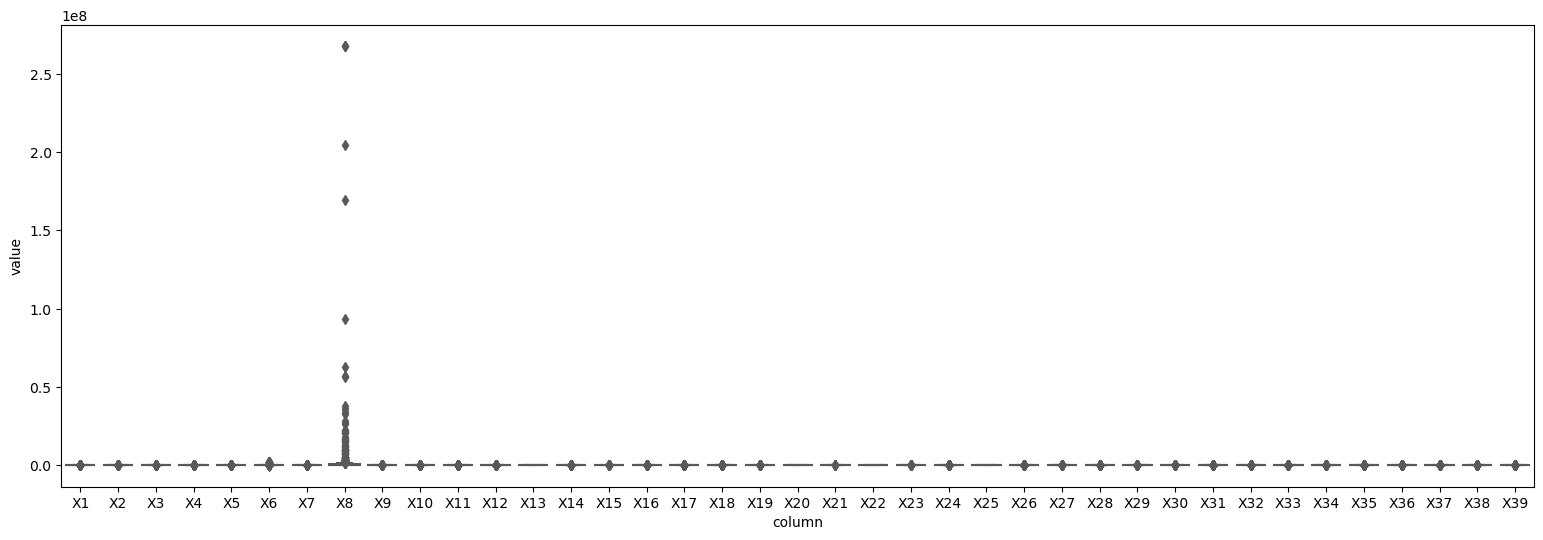

In [5]:
df_train_copy = df_final_train.copy()
df_test_copy = df_final_test.copy()

# Escala raíz cuadrada a las que se dispersan mucho
df_train_copy[['X1','X2','X3','X4','X5','X7','X10','X11']] = np.sqrt(df_train_copy[['X1','X2','X3','X4','X5','X7','X10','X11']])
df_test_copy[['X1','X2','X3','X4','X5','X7','X10','X11']] = np.sqrt(df_test_copy[['X1','X2','X3','X4','X5','X7','X10','X11']])

# Escala logarítmica a las que se dispersan mucho
# df_train_copy[['X1','X2','X3','X4','X5','X7','X10','X11']] = np.log(df_train_copy[['X1','X2','X3','X4','X5','X7','X10','X11']])
# df_test_copy[['X1','X2','X3','X4','X5','X7','X10','X11']] = np.log(df_test_copy[['X1','X2','X3','X4','X5','X7','X10','X11']])

df_melted = df_train_copy.melt(var_name='column')

plt.figure(figsize=(19,6))
sns.boxplot(data=df_melted, color="#3BA3EC", x="column", y="value")

In [6]:
#1. Quitar outliers

modelo_isof = IsolationForest(
                n_estimators  = 1000,
                max_samples   ='auto',
                contamination = 0.1,
                n_jobs        = -1,
                random_state  = 123,
            )

df_no_na = df_train_copy.dropna(axis=0, inplace=False)

modelo_isof.fit(X=df_no_na)
clasificacion_predicha = modelo_isof.predict(X=df_no_na)
clasificacion_predicha

df_no_na['clasificacion_predicha'] = clasificacion_predicha
indices_outliers = df_no_na.index[df_no_na['clasificacion_predicha'] == -1].tolist()

indices_outliers

df_no_outliers = df_train_copy.drop(index=indices_outliers)

# Ahora, imputo sobre el dataset sin outliers
# imp_train = KNNImputer(n_neighbors=5).fit(df_no_outliers)
# df_train_imp = pd.DataFrame(imp_train.transform(df_train_copy), columns=df_train_copy.columns, index=df_train_copy.index)

imp_train = SimpleImputer(missing_values=np.nan, strategy='median').fit(df_no_outliers) #most_frequent
df_train_imp = pd.DataFrame(imp_train.transform(df_train_copy), columns=df_train_copy.columns, index=df_train_copy.index)

# Hago lo mismo para test
modelo_isof_test = IsolationForest(
                n_estimators  = 1000,
                max_samples   ='auto',
                contamination = 0.1,
                n_jobs        = -1,
                random_state  = 123,
            )

df_no_na_test = df_test_copy.dropna(axis=0, inplace=False)

modelo_isof_test.fit(X=df_no_na_test)
clasificacion_predicha = modelo_isof_test.predict(X=df_no_na_test)
clasificacion_predicha

df_no_na_test['clasificacion_predicha'] = clasificacion_predicha
indices_outliers = df_no_na_test.index[df_no_na_test['clasificacion_predicha'] == -1].tolist()

indices_outliers

df_no_outliers_test = df_test_copy.drop(index=indices_outliers)

# imp_test = KNNImputer(n_neighbors=5).fit(df_no_outliers_test)
# df_test_imp = pd.DataFrame(imp_test.transform(df_test_copy), columns=df_test_copy.columns, index=df_test_copy.index)

#Imputamos con mediana
imp_test = SimpleImputer(missing_values=np.nan, strategy='median').fit(df_no_outliers_test)
df_test_imp = pd.DataFrame(imp_test.transform(df_test_copy), columns=df_test_copy.columns, index=df_test_copy.index)

In [7]:
# # 4. Escalamos
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_train_imp.to_numpy())
df_scaled = pd.DataFrame(df_scaled,index=df_train_imp.index, columns=[df_train_imp.columns])

df_scaled_test = scaler.transform(df_test_imp.to_numpy())
df_scaled_test = pd.DataFrame(df_scaled_test,index=df_test_imp.index, columns=[df_test_imp.columns])

# # 5. Componemos las columnas
columns = ['ID']
columns = np.append(columns, df_train_copy.columns)
columns = np.append(columns, 'RATE')

result_df_train = pd.merge(train_ID, df_scaled, left_index=True, right_index=True)
result_df_train = pd.merge(result_df_train, train_RATE, left_index=True, right_index=True)
result_df_train.columns = columns

columns = ['ID']
columns = np.append(columns, df_test_copy.columns)

result_df_test = pd.merge(test_ID, df_scaled_test, left_index=True, right_index=True)
result_df_test.columns = columns

#### Aplicación de Optuna

In [8]:
X = result_df_train.drop(['ID','RATE'], inplace=False, axis=1)
y = result_df_train['RATE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define la función objetivo
def objective(trial):
    
    # Define el espacio de búsqueda de hiperparámetros
    C = trial.suggest_loguniform('C', 0.001, 10000)
    gamma = trial.suggest_loguniform('gamma', 0.001, 10000)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    degree = trial.suggest_int('degree', 1, 10)
    shrinking = trial.suggest_categorical('shrinking', [True, False])
    coef0 = trial.suggest_uniform('coef0', 0.0, 10.0)
    class_weight = trial.suggest_categorical('class_weight', ['balanced', None])

    # Crea y entrena el modelo SVM
    classifier_obj = svm.SVC(C=C, gamma=gamma, kernel=kernel, degree=degree, shrinking=shrinking, coef0=coef0, class_weight=class_weight)
    classifier_obj.fit(X_train, y_train)

    # Evalúa el modelo
    y_pred = classifier_obj.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy


In [14]:
# np.random.seed(1234)

# Crea el estudio y optimiza
study = optuna.create_study(direction = 'maximize', sampler = optuna.samplers.TPESampler(seed=1234))
study.optimize(objective, n_trials = 100, show_progress_bar = True)

# Imprime los mejores hiperparámetros
print('Best trial:')
trial = study.best_trial
print(" Value: ", trial.value)
print(" Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# Imprime el informe de clasificación del mejor ensayo
best_trial = study.best_trial
best_classifier = SVC(**best_trial.params)
best_classifier.fit(X_train, y_train)
y_pred = best_classifier.predict(X_test)
print(classification_report(y_test, y_pred))

[I 2024-01-19 02:10:33,156] A new study created in memory with name: no-name-93bdd36f-f376-4946-8ef7-1801c6494d78


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2024-01-19 02:10:33,214] Trial 0 finished with value: 0.5808823529411765 and parameters: {'C': 0.02190968595786366, 'gamma': 22.634004467821956, 'kernel': 'poly', 'degree': 3, 'shrinking': False, 'coef0': 8.759326347420947, 'class_weight': None}. Best is trial 0 with value: 0.5808823529411765.
[I 2024-01-19 02:10:33,256] Trial 1 finished with value: 0.47794117647058826 and parameters: {'C': 60.847192724058154, 'gamma': 97.47970110758654, 'kernel': 'poly', 'degree': 8, 'shrinking': True, 'coef0': 6.153961784334937, 'class_weight': None}. Best is trial 0 with value: 0.5808823529411765.
[I 2024-01-19 02:10:33,292] Trial 2 finished with value: 0.5257352941176471 and parameters: {'C': 3403.9307321092724, 'gamma': 36.27830624390474, 'kernel': 'poly', 'degree': 9, 'shrinking': False, 'coef0': 1.4376682451456457, 'class_weight': None}. Best is trial 0 with value: 0.5808823529411765.
[I 2024-01-19 02:10:35,105] Trial 3 finished with value: 0.6727941176470589 and parameters: {'C': 0.034005153

In [15]:
#  Predicciones para el conjunto de entrenamiento
y_train_pred = best_classifier.predict(X_train)

# Calcula la precisión en el conjunto de entrenamiento
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f'Train accuracy: {train_accuracy}')

# Calcula la precisión en el conjunto de validación
test_accuracy = accuracy_score(y_test, y_pred)
print(f'Test accuracy: {test_accuracy}')

Train accuracy: 0.7523659305993691
Test accuracy: 0.6727941176470589


In [12]:
X_final = result_df_test.drop('ID', axis=1, inplace=False)
test_ID = result_df_test['ID'].copy()

y_pred = best_classifier.predict(X_final)
df_pred = pd.DataFrame({'ID':test_ID,'TARGET':y_pred})

df_pred.to_csv('../Resultados/prediccion_optuna.csv', index=False, sep=',')

ValueError: Found input variables with inconsistent numbers of samples: [272, 389]

#### Aplicación de Optuna con Validación Cruzada

In [14]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

X = result_df_train.drop(['ID','RATE'], inplace=False, axis=1)
y = result_df_train['RATE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define la función objetivo
def objective(trial):
    
    # Define el espacio de búsqueda de hiperparámetros
    C = trial.suggest_loguniform('C', 0.001, 10000)
    gamma = trial.suggest_loguniform('gamma', 0.001, 10000)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    degree = trial.suggest_int('degree', 1, 10)
    shrinking = trial.suggest_categorical('shrinking', [True, False])
    coef0 = trial.suggest_uniform('coef0', 0.0, 10.0)
    class_weight = trial.suggest_categorical('class_weight', ['balanced', None])

    # Crea el modelo SVM
    classifier_obj = SVC(C=C, gamma=gamma, kernel=kernel, degree=degree, shrinking=shrinking, coef0=coef0, class_weight=class_weight)

    # Define la validación cruzada estratificada
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)

    # Realiza la validación cruzada
    scores = cross_val_score(classifier_obj, X_train, y_train, cv = skf, scoring = 'accuracy') #cv = 5

    # Devuelve la media de las puntuaciones de la validación cruzada
    return scores.mean()

In [18]:
# Crea el estudio y optimiza
study = optuna.create_study(direction='maximize', sampler = optuna.samplers.TPESampler(seed=1234))
study.optimize(objective, n_trials=100, show_progress_bar=True)

# Imprime los mejores hiperparámetros
print('Best trial:')
trial = study.best_trial
print(" Value: ", trial.value)
print(" Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# Imprime el informe de clasificación del mejor ensayo
best_trial = study.best_trial
best_classifier = SVC(**best_trial.params)
best_classifier.fit(X_train, y_train)
y_pred = best_classifier.predict(X_test)
print(classification_report(y_test, y_pred))

[I 2024-01-12 20:38:40,015] A new study created in memory with name: no-name-0b2a8cfd-8391-4bc6-b99e-d33cd7388b3b


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-01-12 20:38:40,141] Trial 0 finished with value: 0.5804274465691789 and parameters: {'C': 0.02190968595786366, 'gamma': 22.634004467821956, 'kernel': 'poly', 'degree': 3, 'shrinking': False, 'coef0': 8.759326347420947, 'class_weight': None}. Best is trial 0 with value: 0.5804274465691789.
[I 2024-01-12 20:38:40,277] Trial 1 finished with value: 0.48267716535433075 and parameters: {'C': 60.847192724058154, 'gamma': 97.47970110758654, 'kernel': 'poly', 'degree': 8, 'shrinking': True, 'coef0': 6.153961784334937, 'class_weight': None}. Best is trial 0 with value: 0.5804274465691789.
[I 2024-01-12 20:38:40,387] Trial 2 finished with value: 0.5094488188976378 and parameters: {'C': 3403.9307321092724, 'gamma': 36.27830624390474, 'kernel': 'poly', 'degree': 9, 'shrinking': False, 'coef0': 1.4376682451456457, 'class_weight': None}. Best is trial 0 with value: 0.5804274465691789.
[I 2024-01-12 20:38:48,963] Trial 3 finished with value: 0.6198725159355081 and parameters: {'C': 0.034005153

In [16]:
X_final = result_df_test.drop('ID', axis=1, inplace=False)
test_ID = result_df_test['ID'].copy()

y_pred = best_classifier.predict(X_final)
df_pred = pd.DataFrame({'ID':test_ID,'TARGET':y_pred})

df_pred.to_csv('../Resultados/prediccion_op_cv.csv', index=False, sep=',')

#### Aplicación de Optuna con ADASYN

In [15]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.over_sampling import ADASYN

X = result_df_train.drop(['ID','RATE'], inplace=False, axis=1)
y = result_df_train['RATE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Crea el sobremuestreador
adasyn = ADASYN(random_state=42)

# Ajusta y aplica el sobremuestreador
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

# Define la función objetivo
def objective(trial):
    
    # Define el espacio de búsqueda de hiperparámetros
    C = trial.suggest_loguniform('C', 0.001, 10000)
    gamma = trial.suggest_loguniform('gamma', 0.001, 10000)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    degree = trial.suggest_int('degree', 1, 10)
    shrinking = trial.suggest_categorical('shrinking', [True, False])
    coef0 = trial.suggest_uniform('coef0', 0.0, 10.0)
    class_weight = trial.suggest_categorical('class_weight', ['balanced', None])
    
    # Crea el modelo SVM
    classifier_obj = SVC(C=C, gamma=gamma, kernel=kernel, degree=degree, shrinking=shrinking, coef0=coef0, class_weight=class_weight)

    # Define la validación cruzada estratificada
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)

    # Realiza la validación cruzada
    scores = cross_val_score(classifier_obj, X_train, y_train, cv = skf, scoring = 'accuracy') #cv = 5

    # Devuelve la media de las puntuaciones de la validación cruzada
    return scores.mean()

In [16]:
# np.random.seed(1234)

# Crea el estudio y optimiza
study = optuna.create_study(direction = 'maximize', sampler = optuna.samplers.TPESampler(seed=1234))
study.optimize(objective, n_trials = 100, show_progress_bar = True)

# Imprime los mejores hiperparámetros
print('Best trial:')
trial = study.best_trial
print(" Value: ", trial.value)
print(" Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# Imprime el informe de clasificación del mejor ensayo
best_trial = study.best_trial
best_classifier = SVC(**best_trial.params)
best_classifier.fit(X_train_resampled, y_train_resampled)
y_pred = best_classifier.predict(X_test)
print(classification_report(y_test, y_pred))

[I 2024-01-13 19:38:07,503] A new study created in memory with name: no-name-163951d6-205f-4e39-ba02-9db63b068a17


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-01-13 19:38:07,611] Trial 0 finished with value: 0.5804274465691789 and parameters: {'C': 0.02190968595786366, 'gamma': 22.634004467821956, 'kernel': 'poly', 'degree': 3, 'shrinking': False, 'coef0': 8.759326347420947, 'class_weight': None}. Best is trial 0 with value: 0.5804274465691789.
[I 2024-01-13 19:38:07,745] Trial 1 finished with value: 0.48267716535433075 and parameters: {'C': 60.847192724058154, 'gamma': 97.47970110758654, 'kernel': 'poly', 'degree': 8, 'shrinking': True, 'coef0': 6.153961784334937, 'class_weight': None}. Best is trial 0 with value: 0.5804274465691789.
[I 2024-01-13 19:38:07,855] Trial 2 finished with value: 0.5094488188976378 and parameters: {'C': 3403.9307321092724, 'gamma': 36.27830624390474, 'kernel': 'poly', 'degree': 9, 'shrinking': False, 'coef0': 1.4376682451456457, 'class_weight': None}. Best is trial 0 with value: 0.5804274465691789.
[I 2024-01-13 19:38:16,008] Trial 3 finished with value: 0.6198725159355081 and parameters: {'C': 0.034005153

In [17]:
X_final = result_df_test.drop('ID', axis=1, inplace=False)
test_ID = result_df_test['ID'].copy()

y_pred = best_classifier.predict(X_final)
df_pred = pd.DataFrame({'ID':test_ID,'TARGET':y_pred})

df_pred.to_csv('../Resultados/prediccion_op_sm.csv', index=False, sep=',')

#### Aplicación de Optuna con Selección de variables

In [16]:
from sklearn.feature_selection import SelectKBest, f_classif
from optuna import Trial, create_study
from sklearn import svm
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
import pandas as pd

X = result_df_train.drop(['ID','RATE'], inplace=False, axis=1)
y = result_df_train['RATE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

def objective(trial, X_train, y_train):
    # Define el espacio de búsqueda de hiperparámetros
    C = trial.suggest_loguniform('C', 0.001, 10000)
    gamma = trial.suggest_loguniform('gamma', 0.001, 10000)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    degree = trial.suggest_int('degree', 1, 10)
    shrinking = trial.suggest_categorical('shrinking', [True, False])
    coef0 = trial.suggest_uniform('coef0', 0.0, 10.0)
    class_weight = trial.suggest_categorical('class_weight', ['balanced', None])

    # Selección de características
    k = trial.suggest_int("k", 1, X_train.shape[1])
    selector = SelectKBest(score_func=f_classif, k=k)
    X_train_new = selector.fit_transform(X_train, y_train)

    # Crea el modelo SVM
    classifier_obj = SVC(C=C, gamma=gamma, kernel=kernel, degree=degree, shrinking=shrinking, coef0=coef0, class_weight=class_weight)

    # Realiza la validación cruzada estratificada
    skf = StratifiedKFold(n_splits=5)
    scores = cross_val_score(classifier_obj, X_train_new, y_train, cv=skf, scoring='accuracy')

    # Devuelve la media de las puntuaciones de la validación cruzada
    return scores.mean()

In [17]:
def build_and_train_model(params, X_train, y_train):
    # Extrae los hiperparámetros relevantes para SVC
    svc_params = {key: params[key] for key in ['C', 'gamma', 'kernel', 'degree', 'shrinking', 'coef0', 'class_weight']}
    classifier_obj = SVC(**svc_params)

    # Realiza la selección de características
    k = params['k']
    selector = SelectKBest(score_func=f_classif, k=k)
    X_train_new = selector.fit_transform(X_train, y_train)

    # Entrena el modelo
    classifier_obj.fit(X_train_new, y_train)

    return classifier_obj, selector

# Crea el estudio y optimiza
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=1234))
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=100, show_progress_bar=True)

# Imprime los mejores hiperparámetros
print('Best trial:')
trial = study.best_trial
print(" Value: ", trial.value)
print(" Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# Construye y entrena el modelo con los mejores hiperparámetros
best_classifier, selector = build_and_train_model(trial.params, X_train, y_train)

# Realiza predicciones en el conjunto de emtrenamiento
X_train_new = selector.transform(X_train)
y_pred = best_classifier.predict(X_train_new)

# Realiza predicciones en el conjunto de prueba
X_test_new = selector.transform(X_test)
y_pred = best_classifier.predict(X_test_new)

# Imprime el informe de clasificación del mejor ensayo
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f'Train accuracy: {train_accuracy}')

# Calcula la precisión en el conjunto de validación
test_accuracy = accuracy_score(y_test, y_pred)
print(f'Test accuracy: {test_accuracy}')
print(classification_report(y_test, y_pred))

[I 2024-01-19 02:14:55,327] A new study created in memory with name: no-name-152543ea-89da-4e30-8a1b-b58d2d5e6d25


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-01-19 02:14:55,470] Trial 0 finished with value: 0.5552430946131734 and parameters: {'C': 0.02190968595786366, 'gamma': 22.634004467821956, 'kernel': 'poly', 'degree': 3, 'shrinking': False, 'coef0': 8.759326347420947, 'class_weight': None, 'k': 27}. Best is trial 0 with value: 0.5552430946131734.
[I 2024-01-19 02:14:55,544] Trial 1 finished with value: 0.39911261092363454 and parameters: {'C': 97.47970110758654, 'gamma': 0.3906207266094824, 'kernel': 'sigmoid', 'degree': 9, 'shrinking': False, 'coef0': 0.7538124164297655, 'class_weight': None, 'k': 26}. Best is trial 0 with value: 0.5552430946131734.
[I 2024-01-19 02:14:55,740] Trial 2 finished with value: 0.4037870266216723 and parameters: {'C': 0.6031398783750542, 'gamma': 331.9792967319077, 'kernel': 'rbf', 'degree': 9, 'shrinking': False, 'coef0': 7.045813081895726, 'class_weight': None, 'k': 18}. Best is trial 0 with value: 0.5552430946131734.
[I 2024-01-19 02:14:56,100] Trial 3 finished with value: 0.624596925384327 and 

In [18]:
X_final = result_df_test.drop('ID', axis=1, inplace=False)
X_final_new = selector.transform(X_final)
test_ID = result_df_test['ID'].copy()

y_pred = best_classifier.predict(X_final_new)
df_pred = pd.DataFrame({'ID':test_ID,'TARGET':y_pred})

df_pred.to_csv('../Resultados/prediccion_op_sc.csv', index=False, sep=',')

#### Aplicación de Optuna con selección de variables y resample (No probado correctamente)

In [10]:
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import NearMiss
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import SVC

X = result_df_train.drop(['ID','RATE'], inplace=False, axis=1)
y = result_df_train['RATE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

def objective(trial, X_train, y_train):
    # Define el espacio de búsqueda de hiperparámetros
    C = trial.suggest_loguniform('C', 0.001, 10000)
    gamma = trial.suggest_loguniform('gamma', 0.001, 10000)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    degree = trial.suggest_int('degree', 1, 10)
    shrinking = trial.suggest_categorical('shrinking', [True, False])
    coef0 = trial.suggest_uniform('coef0', 0.0, 10.0)
    class_weight = trial.suggest_categorical('class_weight', ['balanced', None])

    # Selección de características
    k = trial.suggest_int("k", 1, X_train.shape[1])
    selector = SelectKBest(score_func=f_classif, k=k)
    X_train_new = selector.fit_transform(X_train, y_train)

    # Aplica ADASYN (oversampling)
    ada = ADASYN(random_state=42)
    X_res, y_res = ada.fit_resample(X_train_new, y_train)

    # Aplica NearMiss (undersampling)
    nm = NearMiss()
    X_res, y_res = nm.fit_resample(X_res, y_res)

    # Crea el modelo SVM
    classifier_obj = SVC(C=C, gamma=gamma, kernel=kernel, degree=degree, shrinking=shrinking, coef0=coef0, class_weight=class_weight)

    # Realiza la validación cruzada estratificada
    skf = StratifiedKFold(n_splits=5)
    scores = cross_val_score(classifier_obj, X_res, y_res, cv=skf, scoring='accuracy')

    # Devuelve la media de las puntuaciones de la validación cruzada
    return scores.mean()

In [11]:
def build_and_train_model(params, X_train, y_train):
    # Extrae los hiperparámetros relevantes para SVC
    svc_params = {key: params[key] for key in ['C', 'gamma', 'kernel', 'degree', 'shrinking', 'coef0', 'class_weight']}
    classifier_obj = SVC(**svc_params)

    # Realiza la selección de características
    k = params['k']
    selector = SelectKBest(score_func=f_classif, k=k)
    X_train_new = selector.fit_transform(X_train, y_train)

    # Entrena el modelo
    classifier_obj.fit(X_train_new, y_train)

    return classifier_obj, selector

# Crea el estudio y optimiza
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=1234))
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=100, show_progress_bar=True)

# Imprime los mejores hiperparámetros
print('Best trial:')
trial = study.best_trial
print(" Value: ", trial.value)
print(" Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# Construye y entrena el modelo con los mejores hiperparámetros
best_classifier, selector = build_and_train_model(trial.params, X_train, y_train)

# Realiza predicciones en el conjunto de prueba
X_test_new = selector.transform(X_test)
y_pred = best_classifier.predict(X_test_new)

# Imprime el informe de clasificación
print(classification_report(y_test, y_pred))

[I 2024-01-14 23:20:25,014] A new study created in memory with name: no-name-cef3d88f-a750-42a7-8455-65ce8004312e


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-01-14 23:20:29,834] Trial 0 finished with value: 0.6646576790906688 and parameters: {'C': 0.02190968595786366, 'gamma': 22.634004467821956, 'kernel': 'poly', 'degree': 3, 'shrinking': False, 'coef0': 8.759326347420947, 'class_weight': None, 'k': 27}. Best is trial 0 with value: 0.6646576790906688.
[I 2024-01-14 23:20:30,225] Trial 1 finished with value: 0.4600104657247514 and parameters: {'C': 97.47970110758654, 'gamma': 0.3906207266094824, 'kernel': 'sigmoid', 'degree': 9, 'shrinking': False, 'coef0': 0.7538124164297655, 'class_weight': None, 'k': 26}. Best is trial 0 with value: 0.6646576790906688.
[I 2024-01-14 23:20:30,843] Trial 2 finished with value: 0.26143134715025906 and parameters: {'C': 0.6031398783750542, 'gamma': 331.9792967319077, 'kernel': 'rbf', 'degree': 9, 'shrinking': False, 'coef0': 7.045813081895726, 'class_weight': None, 'k': 18}. Best is trial 0 with value: 0.6646576790906688.
[I 2024-01-14 23:20:31,603] Trial 3 finished with value: 0.6578911564625851 and

In [ ]:
X_final = result_df_test.drop('ID', axis=1, inplace=False)
X_final_new = selector.transform(X_final)
test_ID = result_df_test['ID'].copy()

y_pred = best_classifier.predict(X_final_new)
df_pred = pd.DataFrame({'ID':test_ID,'TARGET':y_pred})

df_pred.to_csv('../Resultados/prediccion_op_sc.csv', index=False, sep=',')